In [331]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import seaborn as sns
import itertools

In [332]:
amzn = pd.read_csv('data/AMZN.csv', skiprows=[1])
jnj = pd.read_csv('data/JNJ.csv', skiprows=[1])
mcd = pd.read_csv('data/MCD.csv', skiprows=[1])
nke = pd.read_csv('data/NKE.csv', skiprows=[1])
nvda = pd.read_csv('data/NVDA.csv', skiprows=[1])
spy = pd.read_csv('data/SPY.csv', skiprows=[1])

In [333]:
amzn.head()

,Date,Year,Month,Day,Weekday,Week_Number,Year_Week,Open,High,Low,Close,Volume,Return,Short_MA,Long_MA
0,2020-01-02,2020,1,2,Thursday,0,2020-00,93.75,94.90,93.21,94.90,80580000,0.000000,94.900000,94.900000
1,2020-01-03,2020,1,3,Friday,0,2020-00,93.22,94.31,93.22,93.75,75288000,-0.012139,94.325000,94.325000
2,2020-01-06,2020,1,6,Monday,1,2020-01,93.00,95.18,93.00,95.14,81236000,0.014886,94.596667,94.596667
3,2020-01-07,2020,1,7,Tuesday,1,2020-01,95.22,95.69,94.60,95.34,80898000,0.002092,94.782500,94.782500
4,2020-01-08,2020,1,8,Wednesday,1,2020-01,94.90,95.55,94.32,94.60,70160000,-0.007809,94.746000,94.746000


To cluster the stocks meaningfully, we first need to remove the overall market influence.
We do this by computing monthly residuals from a linear regression of each stock’s daily returns on SPY’s daily returns. The idea is:
- If the residuals are close to 0, the stock behaves very similarly to the market (SPY).
- Larger residuals indicate behavior that diverges more from the market.

For every month, we consider a linear
regression:
Rm(Si) = βm·R∗m + αm + ϵm
The residual ϵm = (ϵ1,...,ϵ20) is a vector. If a month has fewer than 20 days, add additional zeros to make ϵm to have a length of exactly 20. If there are more than 20 days, remove the last few values to make it exactly 20.

Over 5 years, each stock has 60 months, producing 60 residual vectors.
With 5 stocks, we obtain 300 residual objects in total.

These residual vectors serve as the input to our clustering algorithm, allowing us to group stocks based on how similarly they behave after removing SPY’s influence.

In [334]:
def remove_market_influence(stock_df, spy_df, stock_name):
    df1 = stock_df[["Year", "Month", "Day", "Return"]].rename(columns={"Return": "stock_return"})
    df2 = spy_df[["Year", "Month", "Day", "Return"]].rename(columns={"Return": "spy_return"})
    
    merged = pd.merge(df1, df2, on=["Year", "Month", "Day"], how="inner")

    records = []
    resid_cols = [f"eps_{i}" for i in range(1, 21)]

    for (year, month), g in merged.groupby(["Year", "Month"]):
        y = g["stock_return"].values          # Rm(Si)
        x = g["spy_return"].values.reshape(-1, 1)  # R*m

        # linear regression: Rm(Si) = β R*m + α + ε
        if len(y) == 0:
            continue

        reg = LinearRegression()
        reg.fit(x, y)
        pred = reg.predict(x)
        resid = y - pred   # loss function

        # adjust length to exactly 20
        if len(resid) < 20:
            resid = np.pad(resid, (0, 20 - len(resid)), mode="constant", constant_values=0.0)
        elif len(resid) > 20:
            resid = resid[:20]

        rec = {
            "Stock": stock_name,
            "Year": year,
            "Month": month,
        }
        rec.update({col: val for col, val in zip(resid_cols, resid)})
        records.append(rec)
    return pd.DataFrame(records)

In [335]:
stocks = {
    'AMZN': amzn,
    'JNJ': jnj,
    'MCD': mcd,
    'NKE': nke,
    'NVDA':nvda
}
residuals = []
for st_name, st_df in stocks.items():
    resid = remove_market_influence(st_df, spy, st_name)
    residuals.append(resid)
# residuals
residual_all = pd.concat(residuals, ignore_index=True)
print(residual_all.shape)

(300, 23)


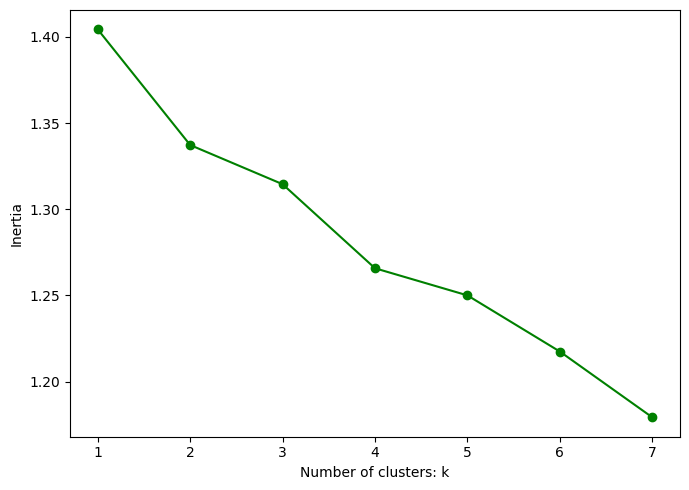

In [336]:
inertia_list = []
k_values = range(1,8)
x = residual_all.iloc[:, 3:].values
for k in k_values:
    kmeans_clust = KMeans(n_clusters=k, random_state=79)
    y_means = kmeans_clust.fit_predict(x)
    inertia = kmeans_clust.inertia_
    inertia_list.append(inertia)
    
fig, ax = plt.subplots(1,figsize=(7,5))
plt.plot(k_values, inertia_list, marker='o', color='green')
# plt.legend()
plt.xlabel('Number of clusters: k')
plt.ylabel('Inertia')
plt.tight_layout()
plt.show()

From the elbow chart, the biggest drop in inertia happens before k = 4. After that, the curve flattens and improvements become small.
So, k = 4 appears to be the visually optimal number of clusters

In [337]:
# optimal k value
k_value = 4
x = residual_all.iloc[:, 3:].values
kmeans_clust = KMeans(n_clusters=k_value, random_state=79)
residual_all['cluster'] = kmeans_clust.fit_predict(x)
centroids = kmeans_clust.cluster_centers_
# centroids

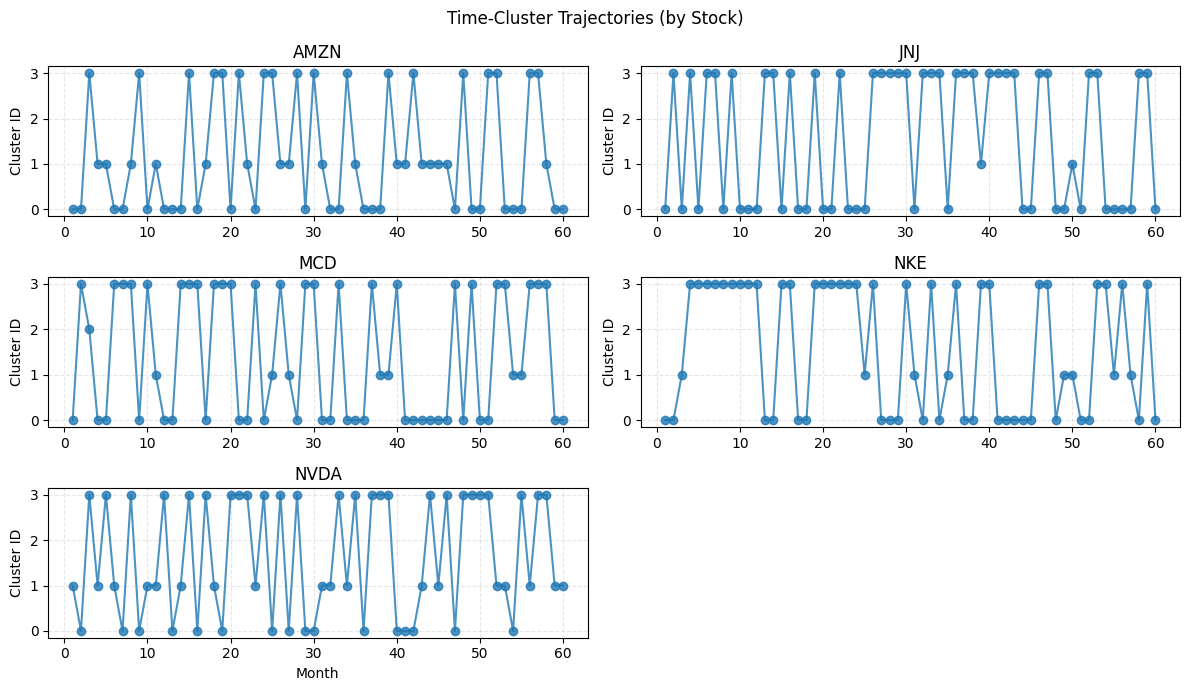

In [338]:
residual_all = residual_all.sort_values(["Stock", "Year", "Month"]).copy()

stocks_list = sorted(residual_all["Stock"].unique())

fig, axes = plt.subplots( 3, 2, figsize=(12, 7))
axes = axes.flatten()
mon_num = range(1, 61)

for ax, stock in zip(axes, stocks_list):
    df_s = (residual_all[residual_all["Stock"] == stock].sort_values(["Year", "Month"]))

    ax.plot(
        mon_num,
        df_s["cluster"],
        marker="o",
        alpha=0.8
    )
    ax.set_title(stock)
    ax.grid(True, linestyle="--", alpha=0.3)
    ax.set_yticks(sorted(residual_all["cluster"].unique()))
    ax.set_ylabel("Cluster ID")
# remove last empty subplot
fig.delaxes(axes[5])

fig.suptitle("Time-Cluster Trajectories (by Stock)")
plt.xlabel("Month")
plt.tight_layout()
plt.show()

After plotting the time-cluster trajectories over the 60-month period, we see that all stocks move between clusters fairly often, meaning their return patterns change from month to month. Still, some stocks behave more consistently than others:

- JNJ is the most stable, especially after month 20. It switches clusters less often and mostly stays within clusters 0 and 3, showing steadier behavior.
- AMZN, MCD, and NVDA are the most variable. These stocks jump between clusters very frequently, especially between clusters 0 and 3, indicating less consistent month-to-month behavior.
- NKE shows mixed behavior. During the first half of the 5-year period, it stays mostly in cluster 3, but later it begins to switch more often between clusters 0 and 3.

Cluster 3 appears the most across all stocks, while cluster 2 is the rarest and only shows up briefly (mainly for MCD).

In [339]:
def longest_streak(arr):
    cnt, res = 1, 1
    for i in range(1, len(arr)):
        if arr[i] == arr[i - 1]:
            cnt += 1
            res = max(res, cnt)
        else: cnt = 1
    return res

def calc_hamming(df):
    st_seqs = {
        stock: df[df["Stock"] == stock].sort_values(["Stock", "Year", "Month"])["cluster"].to_numpy()
        for stock in df["Stock"].unique()
    }
    pairs = []
    for s1, s2 in itertools.combinations(st_seqs.keys(), 2):
        seq1 = st_seqs[s1]
        seq2 = st_seqs[s2]

        # Hamming distance
        h = np.sum(seq1 != seq2)
        pairs.append((s1, s2, h))

    hamming_df = pd.DataFrame(pairs, columns=["Stock_1", "Stock_2", "H"])
    hmax = hamming_df.iloc[hamming_df['H'].idxmax()]
    hmin = hamming_df.iloc[hamming_df['H'].idxmin()]
    print(f"The largest Hamming distance between {hmax.Stock_1} and {hmax.Stock_2} with distance = {hmax.H}")
    print(f"The lowest Hamming distance between {hmin.Stock_1} and {hmin.Stock_2} with distance = {hmin.H}")
    print(f"The average Hamming distance for five stocks {residual_all["Stock"].unique()} = {np.mean(hamming_df['H'])}")
    
    result = []
    for st, st_arr in st_seqs.items():
        result.append({
            "Stock": st,
            "Longest streak": longest_streak(st_arr),
            "Cluster changes": np.sum(st_arr[1:] != st_arr[:-1])
        })
        # print(st, longest_streak(st_arr))
        # print(np.sum(st_arr[1:] != st_arr[:-1]))
    return pd.DataFrame(result)
    # return st_seqs, hamming_df

In [340]:
calc_hamming(residual_all)

The largest Hamming distance between JNJ and NVDA with distance = 50
The lowest Hamming distance between MCD and NKE with distance = 28
The average Hamming distance for five stocks ['AMZN' 'JNJ' 'MCD' 'NKE' 'NVDA'] = 39.5


,Stock,Longest streak,Cluster changes
0,AMZN,4,38
1,JNJ,5,32
2,MCD,6,34
3,NKE,9,30
4,NVDA,4,44


As seen from the time-cluster trajectories, the largest Hamming distance is between JNJ and NVDA (50), meaning these two stocks behaved the most differently in terms of their cluster paths. The lowest Hamming distance is between MCD and NKE (28), showing that their month-to-month patterns were the most similar. Both also have the longest streaks in the same cluster (6 and 9 months), making them relatively more stable.

The average Hamming distance across all five stocks is 39.5, indicating a fairly high level of diversity in how the stocks move between clusters. 

NVDA and AMZN show the most cluster changes (44 and 38), making them the least stable.

In [341]:
period1 = residual_all[residual_all['Year'] <= 2021].copy()
period2 = residual_all[residual_all['Year'] >= 2023].copy()

calc_hamming(period1)

The largest Hamming distance between JNJ and NVDA with distance = 23
The lowest Hamming distance between JNJ and MCD with distance = 12
The average Hamming distance for five stocks ['AMZN' 'JNJ' 'MCD' 'NKE' 'NVDA'] = 15.6


,Stock,Longest streak,Cluster changes
0,AMZN,3,17
1,JNJ,3,16
2,MCD,3,14
3,NKE,9,6
4,NVDA,3,20


For Period 1 (2020–2021), the average Hamming distance drops to 15.6, meaning the stocks behaved more similarly during the early period. Most stocks show short streaks (around 3 months) and moderate switching (14–20 changes). NKE is the most stable here (longest streak = 9 months, only 6 changes), while NVDA remains the most variable (20 changes).

In [342]:
calc_hamming(period2)

The largest Hamming distance between NKE and NVDA with distance = 20
The lowest Hamming distance between MCD and NKE with distance = 11
The average Hamming distance for five stocks ['AMZN' 'JNJ' 'MCD' 'NKE' 'NVDA'] = 16.4


,Stock,Longest streak,Cluster changes
0,AMZN,4,12
1,JNJ,4,11
2,MCD,6,11
3,NKE,5,13
4,NVDA,4,13


For Period 2 (2023–2024), the average Hamming distance is 16.4, similar to Period 1, suggesting moderately diverse behavior. MCD has the longest streak (6 months), while AMZN, NKE, and NVDA switch clusters more often (12–13 times). JNJ and MCD appear the most stable in this period (11 changes each), although the differences across stocks are small, ranging only from 11 to 13 total changes.